In [ ]:


import numpy as np

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import umap.plot
import os

import sys

from scripts.embeddings import find_files_to_kmerize, kmer_sampling_multiple_files, kmerize_parquet_joblib, load_labels


def load_stored_embeddings(dataset_file_path):
    print(f"Loading embeddings from: {dataset_file_path=}")
    z = np.load(dataset_file_path, allow_pickle=True)

    X = list(z["X"])  # object array → list of arrays 
    ids = list(z["ids"])  # map labels from current dict
    return X, ids


def embed_data(label_dict, dir_list, path = None, kmer_prefix="CGTCA", kmer_suffix_size = 4, cores = 4):
	if path is None:
		data_dict = kmerize_parquet_joblib(dir_list, kmer_prefix=kmer_prefix, kmer_suffix_size=kmer_suffix_size, nr_of_cores=cores, output_type="counts")
		ids = [gid for gid in data_dict.keys()]
		X = [data_dict[gid] for gid in ids]
	else:
		X, ids = load_stored_embeddings(path)


	X = [x for gid, x in zip(ids, X) if gid in label_dict]
	y = np.array([label_dict[gid] for gid in ids if gid in label_dict], dtype=np.int64)

	return X, y

	

ModuleNotFoundError: No module named 'embeddings'

In [6]:

labels_path = "../downloads/labels.csv"
input_data_directory = "../downloads"
output_data_directory = input_data_directory


phenotype = "madin_categorical_gram_stain"
label_dict_literal, label_dict, int2label = load_labels(file_path=labels_path, id = "genome_name", label = phenotype, sep = ",")


file_suffix = ".parquet"
dir_list = os.listdir(input_data_directory)
dir_list = [f'{input_data_directory}/{file}' for file in dir_list if file_suffix in file]

print(f'{dir_list=}')


dir_list=['../downloads/train_03.parquet', '../downloads/train_02.parquet', '../downloads/train_01.parquet']


Kmerizing ../downloads/train_03.parquet
Kmerizing ../downloads/train_02.parquetLoading parquet dataset: ../downloads/train_03.parquet

Kmerizing ../downloads/train_01.parquetLoading parquet dataset: ../downloads/train_02.parquet

Loading parquet dataset: ../downloads/train_01.parquet
Processed 3/3 files.
Nr of sequences in dataset: 1470
[0.47549765 0.06969033]


/var/folders/sc/q50j7pq53n3d66jypdgbp6_00000gn/T/ipykernel_47128/899255298.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Label', frameon=False)


NameError: name 'kmer_prefix' is not defined

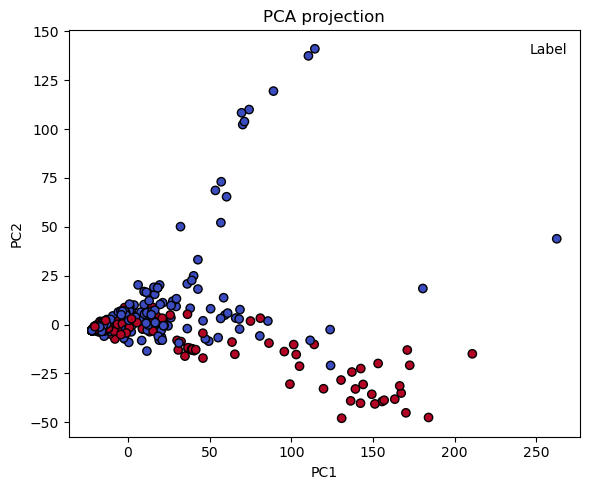

In [ ]:
X, y = embed_data(label_dict=label_dict, dir_list=dir_list, kmer_prefix="CGTCAC", kmer_suffix_size = 6, cores = 4)




In [ ]:
pca = PCA(n_components=2, random_state=0)
X_pcs = pca.fit_transform(X)

print(pca.explained_variance_ratio_)

labels = np.unique(y)

label2id = {label: i for i, label in enumerate(labels) }

color_list = [label2id[l] for l in y]

plt.figure(figsize=(6,5))

plt.scatter(X_pcs[:, 0], X_pcs[:, 1], c=color_list, cmap='coolwarm', edgecolor='k')
plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('PCA projection')
plt.legend(title='Label', frameon=False)
plt.tight_layout()
plt.savefig(f'results/pca_analysis_{phenotype}_prefix_{kmer_prefix}_suffix_size_{kmer_suffix_size}.jpg')




<Axes: >

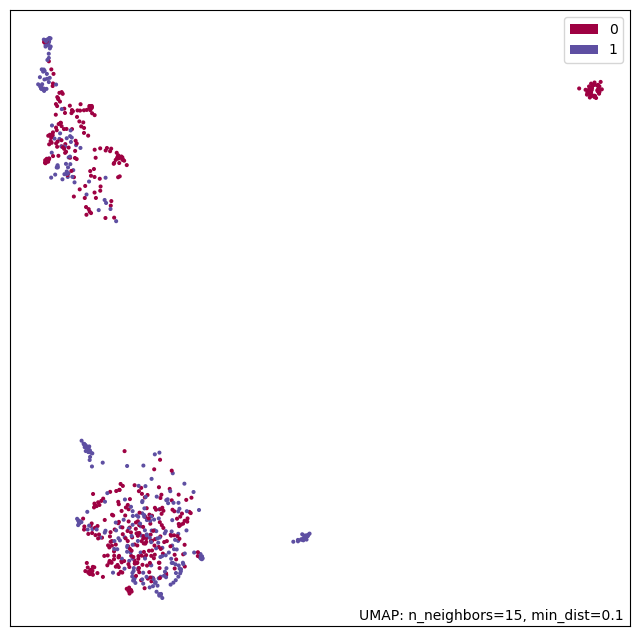

In [9]:
mapper = umap.UMAP().fit(X)
umap.plot.points(mapper, labels = y)